In [3]:
import matplotlib.pyplot as plt
import librosa.feature
import librosa.display
import numpy as np
from IPython.display import Audio, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ruptures as rpt  # our package
import IPython.display as ipd

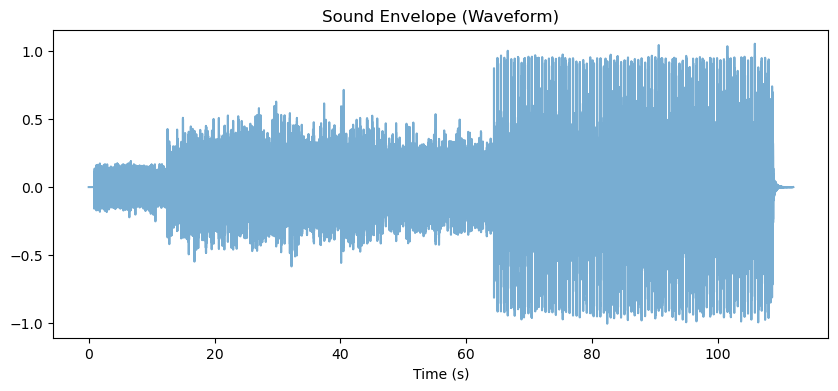

In [4]:
duration = 112  # in seconds
signal, sampling_rate = librosa.load(
    r"C:\Users\nicol\Documents\GitHub\Music-Structure-Analysis\DO NOT TOUCH\Audio Files\Emmanuel\01. Vitalic - Polkamatic.flac", duration=duration)

# listen to the music
display(Audio(data=signal, rate=sampling_rate))

# Plot waveform
time = np.arange(len(signal)) / sampling_rate
plt.figure(figsize=(10, 4))
plt.plot(time, signal, alpha=0.6)
plt.xlabel("Time (s)")
plt.title("Sound Envelope (Waveform)")
plt.show()

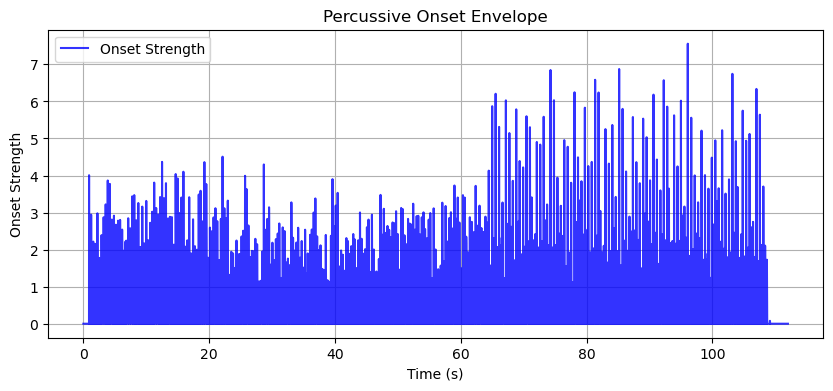

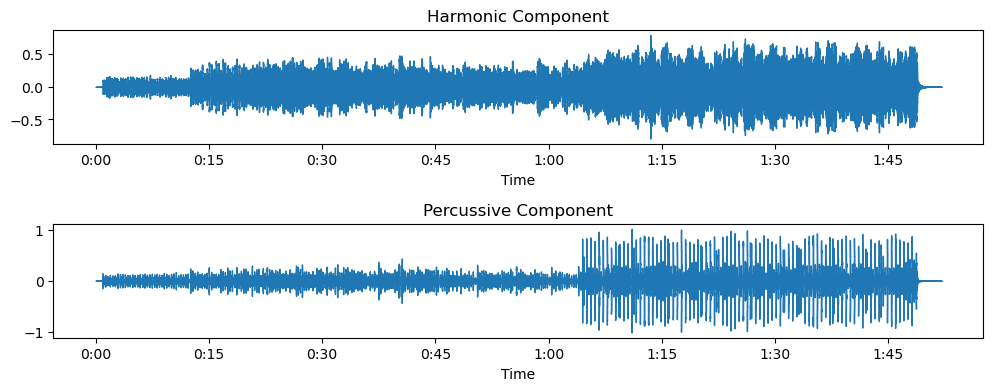

In [4]:
# Enhanced onset strength detection
hop_length_tempo = 112  # long window i guess as others are at 200 ish
y_harmonic, y_percussive = librosa.effects.hpss(signal)  # Separate percussive elements
'''
Okay so the, y_harmonic: harmonics, synth, melodies, if vocals.
y_percussive: percussive parts, drums, snares, hi-hats
'''

# Onset strength detection
oenv = librosa.onset.onset_strength(y=y_percussive, sr=sampling_rate, hop_length=112, aggregate=np.median)
times = librosa.frames_to_time(np.arange(len(oenv)), sr=sampling_rate, hop_length=112)

#viz the oenv
times = librosa.frames_to_time(np.arange(len(oenv)), sr=sampling_rate, hop_length=hop_length_tempo)

# Plot the onset envelope
plt.figure(figsize=(10, 4))
plt.plot(times, oenv, label="Onset Strength", color="blue", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.title("Percussive Onset Envelope")
plt.legend()
plt.grid(True)
plt.show()

'''
the peaks in the onset envelope, strong drums
regular hits, kicks snares.
sudden changes, drops / breakdowns
'''

# Display both components
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_harmonic, sr=sampling_rate)
plt.title("Harmonic Component")

plt.subplots_adjust(hspace=0.7)

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_percussive, sr=sampling_rate)
plt.title("Percussive Component")
plt.show()


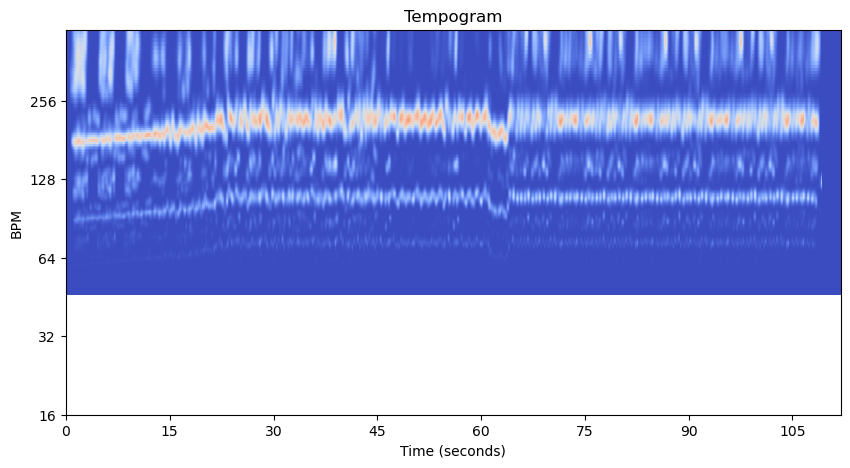

In [5]:
# tempogram getting made :))
win_length = 256  # Larger window to better capture EDM's structured rhythm
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sampling_rate, hop_length=hop_length_tempo, win_length=win_length)

# Display tempogram
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(tempogram, ax=ax, hop_length=hop_length_tempo, sr=sampling_rate, x_axis="s", y_axis="tempo")
ax.set_title("Tempogram")
# fig.colorbar(img, ax=ax, format="%+2.0f BPM")
plt.show()


In [ ]:
# Kernel change point detection from ruptures.
# changes in rhythem energy, texture, tempo, instrumentation.
algo = rpt.KernelCPD(kernel="rbf").fit(tempogram.T)
bkps = algo.predict(n_bkps=min(12, tempogram.shape[1] // 5))
# Convert frame indices to time
bkps_times = librosa.frames_to_time(bkps, sr=sampling_rate, hop_length=512)

# Ensure segments are at least X seconds apart
min_segment_length = 3  # in seconds
filtered_bkps_times = [bkps_times[0]]  # Always keep the first change point
for b in bkps_times[1:]:
    if b - filtered_bkps_times[-1] >= min_segment_length:
        filtered_bkps_times.append(b)

# Ensure the final segment reaches the end
if filtered_bkps_times[-1] != bkps_times[-1]:
    filtered_bkps_times.append(bkps_times[-1])

# Use filtered breakpoints
bkps_times = np.array(filtered_bkps_times)
print(bkps_times)

NameError: name 'tempogram' is not defined

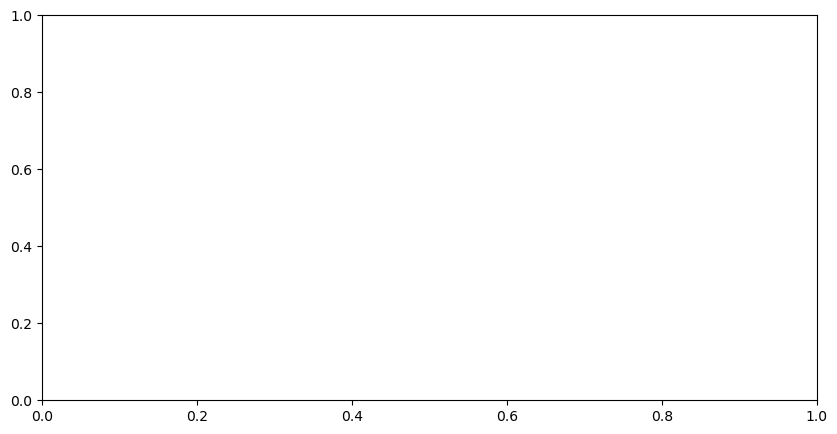

In [5]:
import pandas as pd

# Visuals of detected changes
fig, ax = plt.subplots(figsize=(10, 5))
librosa.display.specshow(tempogram, ax=ax, hop_length=hop_length_tempo, sr=sampling_rate, x_axis="s", y_axis="tempo")
ax.set_title("Segment Change Points")

plt.show()

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="red", lw=2)
    print(f"Change detected at: {b:.2f} seconds")

# === CALCULATES SCORE WITHIN 3s OF GT ====
def gaussian_score_flat_top(time_diff, sigma=0.9, flat_top=0.25):
    abs_diff = abs(time_diff)
    if abs_diff <= flat_top:
        return 100.0
    elif abs_diff >= 3:
        return 0.0
    else:
        adjusted_diff = abs_diff - flat_top
        return 100.0 * math.exp(- (adjusted_diff ** 2) / (2 * sigma ** 2))

# === Load ground truth from CSV ===
ground_truth_path = r"Music-Structure-Analysis\DO NOT TOUCH\GroundTruthData\GroundTruthLeft\parsed_data_1.csv"
gt_times = pd.read_csv(ground_truth_path)['TIMESTAMP'].values  # Extract 'TIMESTAMP' column

# Extract segments and display their timestamps
bkps_time_indexes = (sampling_rate * bkps_times).astype(int).tolist()

# store the segments into an array for later
audio_segments = []

for segment_number, (start, end) in enumerate(rpt.utils.pairwise([0] + bkps_time_indexes), start=1):
    start_time = start / sampling_rate
    end_time = end / sampling_rate
    duration = (end - start) / sampling_rate

    segment_audio = signal[start:end]  # Extract segments
    audio_segments.append(segment_audio)

    print(f"Segment {segment_number}: {start_time:.2f}s - {end_time:.2f}s (Duration: {duration:.2f}s)")
    # display(Audio(data=signal[start:end], rate=sampling_rate))

print("number of segments: {}".format(len(audio_segments)))

# === Scoring ===
scores = []
matched_preds = []

for gt in gt_times:
    if len(bkps_times) == 0:
        scores.append(0.0)
        matched_preds.append(None)
        continue
    closest_pred = min(bkps_times, key=lambda p: abs(p - gt))
    matched_preds.append(closest_pred)
    time_diff = closest_pred - gt
    score = gaussian_score_flat_top(time_diff)
    scores.append(score)

# === Results ===
print("\n--- Evaluation Results ---")
for i, (gt, pred, score) in enumerate(zip(gt_times, matched_preds, scores), 1):
    print(f"{i:02}: GT={gt:.2f}s | Closest Pred={pred:.2f}s | Diff={pred - gt:+.2f}s | Score={score:.2f}")

avg_score = np.mean(scores)
print(f"\nAverage Score: {avg_score:.2f}")

7


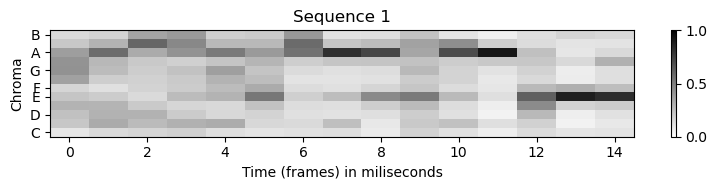

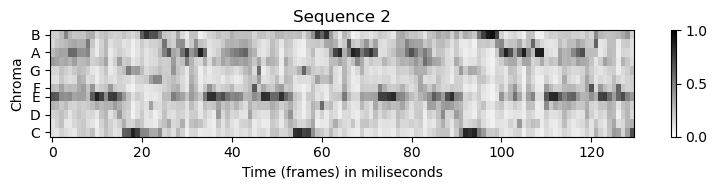

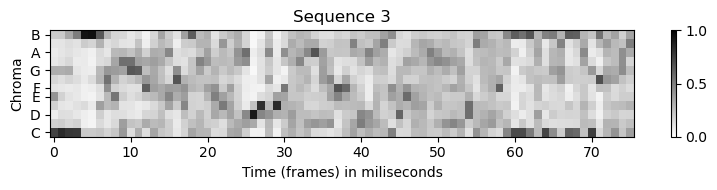

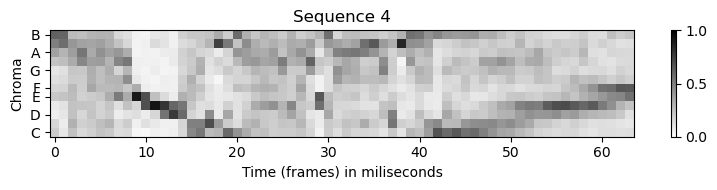

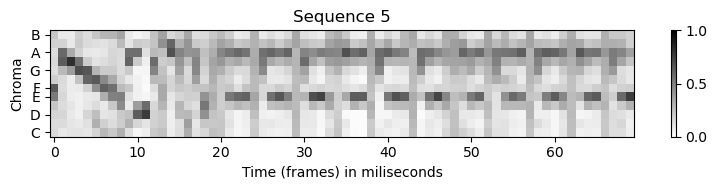

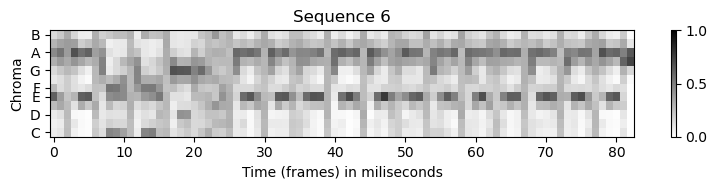

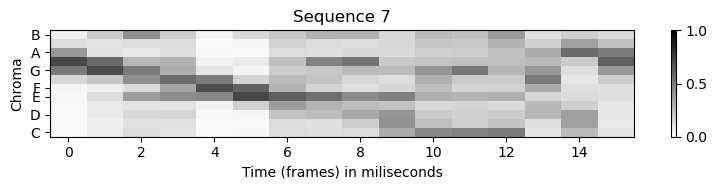

In [112]:
# see if the audio is loaded in
print(len(audio_segments))
# print(audio_segments)

# frame rate sample?
Fs = 22050

# load the files :)
X_wav = audio_segments[0]

# Parameters for chroma features - change them if you like?
N = 4410  # FFT window size
H = 2205  # Hop length

for i, X_wav in enumerate(audio_segments):
    X = librosa.feature.chroma_stft(y=X_wav, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)

    #plots it
    plt.figure(figsize=(8, 2))
    plt.title(f'Sequence {i+1}')
    librosa.display.specshow(X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
    plt.xlabel('Time (frames) in miliseconds')
    plt.ylabel('Chroma')
    plt.colorbar()
    plt.clim([0, 1])
    plt.tight_layout()
    plt.show()

    # This plays the audio - can be commented out :)
    ipd.display(ipd.Audio(X_wav, rate=Fs))
